# Treatment of Covid-19 with Remdesivir - Systematic Review and Meta-Analysis

In [1]:
from bs4 import BeautifulSoup
import copy
import forestplot as fp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from urllib.request import Request, urlopen
from urllib.error import HTTPError

## Search pubmed for appropriate studies
1. Click on this [link](https://pubmed.ncbi.nlm.nih.gov/)
2. Type "(((((((covid[Title/Abstract]) OR (corona[Title/Abstract])) OR (sars-cov-2[Title/Abstract])) OR (sars cov 2[Title/Abstract])) AND (remdesivir[Title])) NOT (Meta Analysis[Title])) NOT (Meta-Analysis[Title])) NOT (Review[Title])" into search box

3. On the left hand side check "Free Full Text"
4. Click on save and select <b>all results</b> (not all resutls on page) in selection and format Pubmed
5. Click on create file and save it under the name <b>search_results.txt</b>

## Automated Filtering
### Filter for Randomized Control Trials
We only want to include randomized control trials in our meta-analysis. We are using a machine learning tool called robotsearch to filter out only the studies from the pubmed search which used a ranodmized control trial design.
1. Move the file search_results.txt into the robotsearch directory
2. Open Anaconda
3. `cd` your way into the robotsearch directory within the overall covid_systematic_review directory you downloaded from github
4. If the environment is not activated type `conda activate covid_review`.
5. Run `python setup.py install`.
6. Run `robotsearch search_results.txt -p` Don't forget the -p-flag, or the results will contain too many false positive you will have to manually check later.

The results are saved in the file search_reults_robotviewer_RCTs.txt. Let's look at the result

In [2]:
from robotsearch.parsers import ris
file_input = "robotsearch/search_results.txt"
file_result = "robotsearch/search_results_robotreviewer_RCTs.txt"
with open(file_input, 'r', encoding="utf8") as f:
    inp = ris.load(f)
with open(file_result, 'r', encoding="utf8") as f:
    result = ris.load(f)
print("The inital search result has {} articles".format(len(inp)))
print("{} articles were classified as rcts".format(len(result)))

other non numbered
other non numbered
The inital search result has 671 articles
25 articles were classified as rcts


In [3]:
#extract PMC - they are found in the 'PMC' key.
pmcs = []
for i in range(len(result)):
    if "PMC" in result[i].keys():
        id_raw = result[i]['PMC'][0]
        pmc = id_raw.strip()
        pmcs.append(pmc)

print("{} studies have a pmc-identifier and can be accessed through pubmed open-access".format(len(pmcs)))

25 studies have a pmc-identifier and can be accessed through pubmed open-access


### Filter for Outcome
Let's reduce the number even further by checking if the article contains necessary information. Here we only want articles that use time to clinical improvement. The article has to include the meassure hazard-ratio or rate-ratio!

In [4]:
site= "https://www.ncbi.nlm.nih.gov/pmc/articles/{}/"
hdr = {'User-Agent': 'Mozilla/5.0'}
regex_mortality = r"method.+(?:(?:mortality|death)|(?:time to(?:clinical improvement|recovery)))" # the outcome meassure must come after the word method, so it is likey mentioned in the methods or results section
regex_hr = r"method.+(?:hazard|rate)[\s-]ratio"
pmcs_outcome = []
for i in range(len(pmcs)):
    print(i)
    url = site.format(pmcs[i])
    req = Request(url,headers=hdr)
    try:
        page = urlopen(req)
        soup = BeautifulSoup(page)
        if re.search(regex_mortality, soup.prettify(), re.DOTALL|re.IGNORECASE) and re.search(regex_hr, soup.prettify(), re.DOTALL|re.IGNORECASE):
            print(True)
            pmcs_outcome.append(pmcs[i])
    except HTTPError:
        print("httperror")

0
True
1
True
2
True
3
True
4
True
5
True
6
True
7
8
9
10
True
11
12
True
13
14
15
16
True
17
True
18
True
19
20
21
True
22
23
24
True


In [6]:
print("{} articles contain mortality/death or time to clinical improvement or recovery and propper outcome meassure".format(len(pmcs_outcome)))
with open("papers_html.txt", "w") as f:
    for pmc in pmcs_outcome:
        f.write("%s\n" % "https://www.ncbi.nlm.nih.gov/pmc/articles/{}/".format(pmc))

14 articles contain mortality/death or time to clinical improvement or recovery and propper outcome meassure


In [7]:
screening_results = pd.DataFrame(columns = ['pmc', 'non_retracted', 'randomized_controlled', 'adults', 'infected', 'remdesivir_only', 'propper_outcome'])
screening_results['pmc'] = np.array(pmcs_outcome)
screening_results.to_csv("screening_results.csv", index = False, sep = ";")
for i in range(len(pmcs_outcome)):
    print("https://www.ncbi.nlm.nih.gov/pmc/articles/{}/".format(pmcs_outcome[i]))

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7262788/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7745180/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8757570/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7377062/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8863204/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8490137/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8279143/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8523116/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7538864/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7190303/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9017992/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7442954/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8439621/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9278225/


## Manual Screening of Articles
Now that we filtered out the promising studies, we must manually check for their eligibility. Even though we automated the classification as randomized controll trial, we must check for errors. We follow the following protocol. Open each of the htmls above by clicking on the link or open the file papers_html.txt. Apply the protocol below to each study individually. Open the file screening_results.csv in a csv-editor of your choice to record your results. Note that the separator is semicolon. Type 1 into the cell if criterion is met and 0 if it is not met. Stop checking the other criteria once you coded one criterion as 0 and continue to the next. Note that initially when this protocol was created, studies had to include a placebo-group. This turned out to too strict a criterion, because only few studies fulfilled all criteria. Therefore we decided to include open-label studies.
### Not retracted
If the article has been retracted, it shows in a red box on top of the webpage. It's impossible to miss.
### Randomized Controlled Trial
Randomized Clinical Trials are those in which patients are assigned randomly to a group receiving treatment with Remdesivir and a placebo-group. Check the abstract and methods secion to check if the papers are randomized control trials. Don't include studies, in which both experimental and control group involves Remdesivir but different dossage. Keywords indicating that a study is not an RCT are: "retrospective" study or analysis or observational cohort study. Note that randomizatin between remdesivir and control must take place. There are studies, in which participants are randomized between two different dosages of remdesivir.
### Majority Aduls. 
Check if proportion of age above 18 is >95%
### Participants infected 
Participants must be infected with Covid-19. No studies analysing Remdesivir as a prevention treatment should be included.
### Remdesivir only 
The only difference between treatment- and control-group should be whether patients received remdesivir or not. Control groups can be placebo or standard-care. If multiple treatments are tested, the study must include a comparison of remdesivir with a placebo or standard care group. If both groups receive remdesivir, but in different dosages you should exclude the study. If there are multiple treatments tested in the same study, there must be a propper comparison of remdesivir and a control-group.
### Propper outcome
To assess the effectiveness of treatment with Remdesivir compared to the placebo or standard-care, there must be a propper effect-meassure reported. 
Check if at least one of the outcomes "time to recovery" or "time to clinical improvement" or equivalent meassures has one of these meassures associated with it: odds-ratio, hazard-ratio, rate-ratio. Keep in mind that what the authors declare as primary outcome might not be the primary outcome for this study. You might even have to look into the appendices to retrieve it.
### Propper outcome
To assess the effectiveness of treatment with Remdesivir compared to the placebo or standard-care, there must be a propper effect-meassure reported. Check if there is a ratio (hazard-, rate-, or odds-ratio) comparing mortality in the remdisivir group to mortality in the control group and/or a ratio comparing time-to recovery or clinical improvement.

## Extract eligable studies
We are going to use the studies that fulfill the above criteria. Execute the cell below to get the studies to be included in the final analysis, after you have comleted and saved the screening of articles.

In [8]:
# Please make sure to save your screening_results.csv properly. In Germany the default seperator is semicolon.
df_screening = pd.read_csv("screening_results.csv",sep=";")
df_screening = df_screening.fillna(0)
df_screening["eligable"] = (df_screening.iloc[:,1:].sum(axis = 1)/6).astype(int).astype(bool)
eligable_studies = list(df_screening.loc[df_screening.eligable == True,"pmc"])
result_table = pd.DataFrame(columns = ['pmc', 'ratio_mortality', 'lower_confidence_bound_mortality', 'upper_confidence_bound_mortality', 'p_value_mortality', 'ratio_recovery', 'lower_confidence_bound_recovery', 'upper_confidence_bound_recovery', 'p_value_recovery','sample_size_remdesivir', 'sample_size_control', 'placebo_controlled'])
result_table['pmc'] = np.array(eligable_studies)
result_table.to_csv("result_table.csv", index = False, sep = ";")
print("{} studies were found to be eligable".format(len(eligable_studies)))
for i in range(len(eligable_studies)):
    print("https://www.ncbi.nlm.nih.gov/pmc/articles/{}/".format(eligable_studies[i]))

0 studies were found to be eligable


## Extract Relevant Data
Open the file result-table.csv. The separator is semicolon. Open the studies one-by-on by clicking on the corresponding url in the output of the cell above. Please follow the protocol below when you record your findings. If a meassure is missing, leave the cell blank.
### Ratio Mortality
Type the value of the hazard- or rate-ratio for mortality. You might have to look into an appendix mentioned in the paper. If mortality-ratios are reported for different time periods, choose the latest. If a study includes hospitalization or death don't include this study, because death itself is the outcome meassure.
### lower confidence bound mortality
The confidence-intervall is usually reported after the ratio. E.g. [95% CI 0·81–1·61] - the example is from an actual paper. You can see that the decimal point is missing. Please type the lower confidence bound (the left one) into the result_table. In the example it would be 0.81.
### upper confidence bound mortality
Equivalently type the upper confidence bound (the right one) into the table. In the example it would be 1.61.
### p-value mortality
Type the p-value into the result-table. It is usually documented right next to the confidence interval. If it isn't you have to look a bit in the results section. If there is only a confidence interval reported, leave the column p-value empty.
### Ratio Recovery
Different studies use different recovery-meassures. You should only report one. If a ratio is reported for time to recovery use that one, if not, look if there is time to improvement or aleviation of symptoms or an equivalent meassure.
Type the value of the hazard- or rate-ratio or odds-ratio. You might have to look into an appendix mentioned in the paper. If mortality-ratios are reported for different time periods, choose the latest.
### lower confidence bound Recovery
The confidence-intervall is usually reported after the ratio. E.g. [95% CI 0·81–1·61] - the example is from an actual paper. You can see that the decimal point is missing. Please type the lower confidence bound (the left one) into the result_table. In the example it would be 0.81.
### upper confidence bound Recovery
Equivalently type the upper confidence bound (the right one) into the table. In the example it would be 1.61.
### p-value Recovery
Type the p-value into the result-table. It is usually documented right next to the confidence interval. If it isn't you have to look a bit in the results section. If there is only a confidence interval reported, leave the column p-value empty.
### sample-sizes
Type the sample-sizes for the remdesivir group and the control-group seperately.
### placebo
check if the control group recevided a placebo or not. If the control-group received a placebo type 1 into the column and else type 0.
### save the file.


## Data Analysis

In [13]:
def pooled_effect(df):
    df_effect = copy.copy(df)
    df_effect = df_effect.iloc[:,1:4]
    df_effect.columns = ["ratio", "l", "u"]
    def st_error(upper, lower):
        return  (np.log(upper) - np.log(lower))/3.92
    def weight(se):
        return 1/(se**2)
    
    df_effect["se"] = df_effect.apply(lambda row : st_error(row["u"], row["l"]), axis = 1)
    df_effect["weight"] = df_effect.apply(lambda row : weight(row["se"]), axis = 1)
    sum_of_weights = df_effect["weight"].sum()
    pooled_effect = np.exp((np.log(df_effect["ratio"])*df_effect["weight"]).sum()/sum_of_weights)
    pooled_se = (1/sum_of_weights)**0.5
    pooled_lower_bound = np.exp(np.log(pooled_effect) - 1.96*pooled_se)
    pooled_upper_bound = np.exp(np.log(pooled_effect) + 1.96*pooled_se)
    return pooled_effect, pooled_lower_bound, pooled_upper_bound
                                      
    

In [9]:
df_results = pd.read_csv("result_table.csv", sep= ";")
df_results

,pmc,ratio_mortality,lower_confidence_bound_mortality,upper_confidence_bound_mortality,p_value_mortality,ratio_recovery,lower_confidence_bound_recovery,upper_confidence_bound_recovery,p_value_recovery,sample_size_remdesivir,sample_size_control,placebo_controlled
0,PMC7262788,0.73,0.52,1.03,NaN,1.29,1.12,1.49,0.001,541,521,1
1,PMC8757570,NaN,NaN,NaN,NaN,1.41,0.73,2.69,NaN,279,283,1
2,PMC8863204,0.88,0.72,1.07,NaN,NaN,NaN,NaN,NaN,634,647,0
3,PMC8279143,1.00,0.40,2.90,NaN,NaN,NaN,NaN,NaN,34,33,0
4,PMC7190303,NaN,NaN,NaN,NaN,1.23,0.87,1.75,0.240,158,78,1
5,PMC7442954,0.76,0.17,3.40,NaN,1.16,0.93,1.43,NaN,193,200,0
6,PMC8439621,NaN,NaN,NaN,NaN,1.11,0.87,1.42,0.390,414,418,0


In [10]:
df_mortality = df_results[["pmc", "ratio_mortality", "lower_confidence_bound_mortality", "upper_confidence_bound_mortality", 
                          "p_value_mortality", "sample_size_remdesivir", "sample_size_control", "placebo_controlled"]]
df_mortality = df_mortality.dropna(subset=['ratio_mortality'])
df_mortality = df_mortality.reset_index(drop=True)
df_mortality

,pmc,ratio_mortality,lower_confidence_bound_mortality,upper_confidence_bound_mortality,p_value_mortality,sample_size_remdesivir,sample_size_control,placebo_controlled
0,PMC7262788,0.73,0.52,1.03,NaN,541,521,1
1,PMC8863204,0.88,0.72,1.07,NaN,634,647,0
2,PMC8279143,1.00,0.40,2.90,NaN,34,33,0
3,PMC7442954,0.76,0.17,3.40,NaN,193,200,0


In [11]:
df_improvement = df_results[["pmc", "ratio_recovery", "lower_confidence_bound_recovery", "upper_confidence_bound_recovery", 
                          "p_value_recovery", "sample_size_remdesivir", "sample_size_control", "placebo_controlled"]]
df_improvement = df_improvement.dropna(subset=["ratio_recovery"])
df_improvement = df_improvement.reset_index(drop=True)
df_improvement


,pmc,ratio_recovery,lower_confidence_bound_recovery,upper_confidence_bound_recovery,p_value_recovery,sample_size_remdesivir,sample_size_control,placebo_controlled
0,PMC7262788,1.29,1.12,1.49,0.001,541,521,1
1,PMC8757570,1.41,0.73,2.69,NaN,279,283,1
2,PMC7190303,1.23,0.87,1.75,0.240,158,78,1
3,PMC7442954,1.16,0.93,1.43,NaN,193,200,0
4,PMC8439621,1.11,0.87,1.42,0.390,414,418,0


In [14]:
row_pooled_mortality = ["mortality_pooled"] + list(pooled_effect(df_mortality))  +[np.nan,df_mortality["sample_size_remdesivir"].sum(),df_mortality["sample_size_control"].sum(),np.nan] 
df_mortality.loc[len(df_mortality)] = row_pooled_mortality
row_pooled_improvement = ["improvement_pooled"] + list(pooled_effect(df_improvement))  +[np.nan,df_improvement["sample_size_remdesivir"].sum(),df_improvement["sample_size_control"].sum(),np.nan] 
df_improvement.loc[len(df_improvement)] = row_pooled_improvement

In [15]:
df_improvement_processed = pd.DataFrame(columns = ["study", "response","effect-size", "ll", "hl", "p", "n_remdesivir", "n_control", "placebo"])
df_improvement_processed[["study", "effect-size", "ll", "hl", "p", "n_remdesivir", "n_control", "placebo"]] = df_improvement[
    ["pmc", "ratio_recovery", "lower_confidence_bound_recovery", "upper_confidence_bound_recovery", "p_value_recovery", "sample_size_remdesivir", "sample_size_control","placebo_controlled"]]
df_improvement_processed["response"] = "recovery"
df_improvement_processed ["placebo"] = df_improvement_processed["placebo"].astype(bool).astype(str)
df_improvement_processed["N"] = df_improvement_processed.n_remdesivir + df_improvement_processed.n_control
df_improvement_processed = df_improvement_processed.sort_values(by=["N"], ascending=False)
df_improvement_processed = df_improvement_processed.reset_index(drop=True)
df_improvement_processed["study"] = df_improvement_processed["study"]+ " i"
df_improvement_processed

,study,response,effect-size,ll,hl,p,n_remdesivir,n_control,placebo,N
0,improvement_pooled i,recovery,1.226016,1.108166,1.356399,NaN,1585,1500,True,3085
1,PMC7262788 i,recovery,1.290000,1.120000,1.490000,0.001,541,521,True,1062
2,PMC8439621 i,recovery,1.110000,0.870000,1.420000,0.390,414,418,False,832
3,PMC8757570 i,recovery,1.410000,0.730000,2.690000,NaN,279,283,True,562
4,PMC7442954 i,recovery,1.160000,0.930000,1.430000,NaN,193,200,False,393
5,PMC7190303 i,recovery,1.230000,0.870000,1.750000,0.240,158,78,True,236


In [16]:
df_mortality_processed = pd.DataFrame(columns = ["study", "response","effect-size", "ll", "hl", "p", "n_remdesivir", "n_control", "placebo"])
df_mortality_processed[["study", "effect-size", "ll", "hl", "p", "n_remdesivir", "n_control", "placebo"]] = df_mortality[
    ["pmc", "ratio_mortality", "lower_confidence_bound_mortality", "upper_confidence_bound_mortality", "p_value_mortality", "sample_size_remdesivir", "sample_size_control","placebo_controlled"]]
df_mortality_processed["response"] = "mortality"
df_mortality_processed ["placebo"] = df_mortality_processed["placebo"].astype(bool).astype(str)
df_mortality_processed["N"] = df_mortality_processed.n_remdesivir + df_mortality_processed.n_control
df_mortality_processed = df_mortality_processed.sort_values(by=["N"], ascending=False)
df_mortality_processed = df_mortality_processed.reset_index(drop=True)
df_mortality_processed["study"] = df_mortality_processed["study"]+ " m"
df_mortality_processed

,study,response,effect-size,ll,hl,p,n_remdesivir,n_control,placebo,N
0,mortality_pooled m,mortality,0.84277,0.71258,0.996747,NaN,1402,1401,True,2803
1,PMC8863204 m,mortality,0.88000,0.72000,1.070000,NaN,634,647,False,1281
2,PMC7262788 m,mortality,0.73000,0.52000,1.030000,NaN,541,521,True,1062
3,PMC7442954 m,mortality,0.76000,0.17000,3.400000,NaN,193,200,False,393
4,PMC8279143 m,mortality,1.00000,0.40000,2.900000,NaN,34,33,False,67


In [17]:
df_total = pd.concat([df_improvement_processed, df_mortality_processed])
df_total = df_total.reset_index(drop=True)
df_total["N"] = df_total["N"].astype("O")
df_total

,study,response,effect-size,ll,hl,p,n_remdesivir,n_control,placebo,N
0,improvement_pooled i,recovery,1.226016,1.108166,1.356399,NaN,1585,1500,True,3085
1,PMC7262788 i,recovery,1.290000,1.120000,1.490000,0.001,541,521,True,1062
2,PMC8439621 i,recovery,1.110000,0.870000,1.420000,0.390,414,418,False,832
3,PMC8757570 i,recovery,1.410000,0.730000,2.690000,NaN,279,283,True,562
4,PMC7442954 i,recovery,1.160000,0.930000,1.430000,NaN,193,200,False,393
5,PMC7190303 i,recovery,1.230000,0.870000,1.750000,0.240,158,78,True,236
6,mortality_pooled m,mortality,0.842770,0.712580,0.996747,NaN,1402,1401,True,2803
7,PMC8863204 m,mortality,0.880000,0.720000,1.070000,NaN,634,647,False,1281
8,PMC7262788 m,mortality,0.730000,0.520000,1.030000,NaN,541,521,True,1062
9,PMC7442954 m,mortality,0.760000,0.170000,3.400000,NaN,193,200,False,393


In [18]:
df_total

,study,response,effect-size,ll,hl,p,n_remdesivir,n_control,placebo,N
0,improvement_pooled i,recovery,1.226016,1.108166,1.356399,NaN,1585,1500,True,3085
1,PMC7262788 i,recovery,1.290000,1.120000,1.490000,0.001,541,521,True,1062
2,PMC8439621 i,recovery,1.110000,0.870000,1.420000,0.390,414,418,False,832
3,PMC8757570 i,recovery,1.410000,0.730000,2.690000,NaN,279,283,True,562
4,PMC7442954 i,recovery,1.160000,0.930000,1.430000,NaN,193,200,False,393
5,PMC7190303 i,recovery,1.230000,0.870000,1.750000,0.240,158,78,True,236
6,mortality_pooled m,mortality,0.842770,0.712580,0.996747,NaN,1402,1401,True,2803
7,PMC8863204 m,mortality,0.880000,0.720000,1.070000,NaN,634,647,False,1281
8,PMC7262788 m,mortality,0.730000,0.520000,1.030000,NaN,541,521,True,1062
9,PMC7442954 m,mortality,0.760000,0.170000,3.400000,NaN,193,200,False,393


### Create Forestplot

<AxesSubplot: xlabel='ratio'>

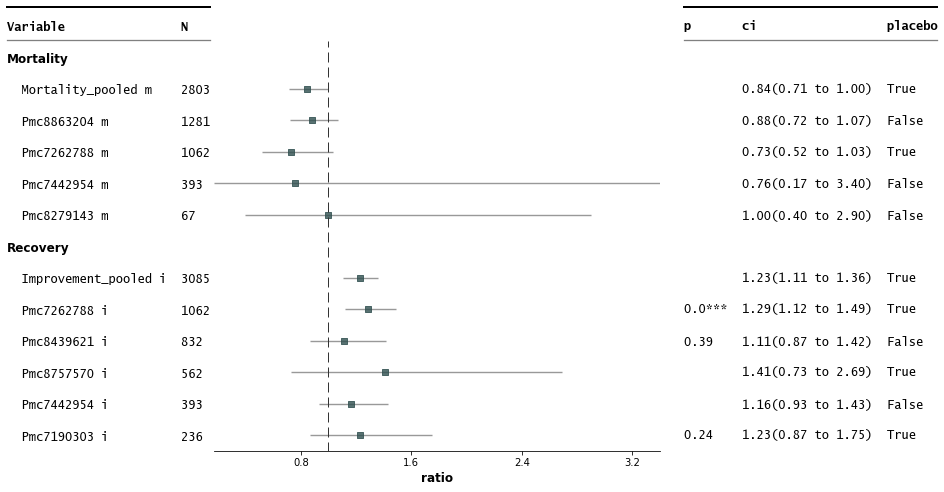

In [19]:
fp.forestplot(df_total,  # the dataframe with results data
              estimate="effect-size",  # col containing estimated effect size 
              ll="ll", hl="hl",  # lower & higher limits of conf. int.
              varlabel="study",  # column containing the varlabels to be printed on far left
              capitalize="capitalize",  # Capitalize labels
              pval="p",  # column containing p-values to be formatted
              annote=["N"],  # columns to report on left of plot
              annoteheaders=["N"],  # ^corresponding headers
              rightannote=["formatted_pval", "est_ci", "placebo"],  # columns to report on right of plot 
              right_annoteheaders=["p","ci","placebo"],  # ^corresponding headers
              groupvar = "response",
              group_order=["mortality", "recovery"],    
              xlabel="ratio",  # x-label title
              xline = 1,
              xlinestyle = (1, (10, 5)),
              figsize = (8,8),
             table=True)